# Topog form stress using MOM025 DATA

Recent update 02 Oct 2017

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import pickle
from numpy import math

import pandas as pd
import xarray as xr
from glob import glob
from mpl_toolkits.basemap import Basemap, shiftgrid


# Load Data

In [2]:
#/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7/output100/ocean/ocean.nc

DataDir = '/g/data3/hh5/tmp/cosima/access-om2-025'
expts = ['025deg_jra55_ryf_spinup7']

In [ ]:
g=9.8

for e in expts:
    ExpDir = os.path.join(DataDir,e)
    FileList1 = glob(os.path.join(ExpDir, 'output10*/ocean/ocean_grid.nc'))
    FileList1.sort()
    dsx1 = xr.open_mfdataset(FileList1, concat_dim='time',decode_times=False, engine='netcdf4')
    kmt_D = dsx1.kmt.mean('time')
    depth_D = dsx1.ht.mean('time')
    FileList2 = glob(os.path.join(ExpDir, 'output10*/ocean/ocean_month.nc'))
    FileList2.sort()
    dsx2 = xr.open_mfdataset(FileList2, concat_dim='time',decode_times=False, engine='netcdf4')    
    pbot_D = dsx2.pbot_t.mean('time')   # p_bot
    FileList3 = glob(os.path.join(ExpDir, 'output10*/ocean/ocean.nc'))
    FileList3.sort()
    dsx3 = xr.open_mfdataset(FileList3, concat_dim='time',decode_times=False, engine='netcdf4')      
    dzt_D = dsx3.dzt.mean('time')      # t-cell thickness
    rho_D = dsx3.rho.mean('time')      # \rho in-situ    

pf=np.zeros([50,1080,1440])# store pbot*dz in each z-cell
mark=np.zeros([50,1080,1440])

for yy in range(100,400):
    kmt = kmt_D.isel(yt_ocean=yy)    # "number of depth levels on t-grid"
    depth = depth_D.isel(yt_ocean=yy).values   # ht, depth
    pbot = pbot_D.isel(yt_ocean=yy).values   # p_bot
    dz = dzt_D.isel(yt_ocean=yy).values        # t-cell thickness
    rho = rho_D.isel(yt_ocean=yy).values       # \rho in-situ    
    z=np.zeros(1440).astype(np.int64)              # define z initial
    z[:]=kmt[:].values-1                # layer number z[x]             
    for x in range(0,1440):
        if (z[x]>-1)&(z[x-1]>-1):      # x & x-1 are not continent landmasses  
            if z[x]-z[x-1]==0:
                dz1=depth[x-1]-depth[x]
                if dz1<0:
                    rhom=rho[z[x],x]
                    pf[z[x-1],yy,x-1]=pf[z[x-1],yy,x-1]+(10000*pbot[x]*(-dz1)-g*rhom*(dz1)**2/2) 
                elif (dz1)>0:
                    rhom=rho[z[x-1],x-1]
                    pf[z[x],yy,x]=pf[z[x],yy,x]-(10000*pbot[x-1]*(dz1)-g*rhom*(dz1)**2/2)
            else:
                if depth[x]-depth[x-1]>0:
                    dz1=depth[x]-depth[x-1]   # total depth difference
                    pa=10000*pbot[x]          # choose pbot pressure
                    zm=dz[z[x],x]             # dz of lowest layer
                    rhom=rho[z[x],x]          # density
                    pm = pa-zm*g*rhom/2       #pressure at middle of each partial cell
                    pf[z[x],yy,x-1]=pf[z[x],yy,x-1]+pm*zm
                    pa=pa-zm*g*rhom           #update press reference to upper partial cell
                    dz1=dz1-zm                    
                    for i in range(1,z[x]-z[x-1]):  #calculate from bottom partial cell in each layer             
                        zm=dz[z[x]-i,x]        
                        rhom=rho[z[x]-i,x]          #density
                        pm = pa-zm*g*rhom/2         #pressure at middle of each partial cell
                        pf[z[x]-i,yy,x-1]=pf[z[x]-i,yy,x-1]+pm*zm
                        mark[z[x]-i,yy,x-1]=1-mark[z[x]-i,yy,x-1]
                        pa=pa-zm*g*rhom             #update press reference to upper partial cell
                        dz1=dz1-zm
                    zm=dz1 # The top cell
                    rhom=rho[z[x-1],x]                
                    pm = pa-zm*g*rhom/2
                    pf[z[x-1],yy,x-1]=pf[z[x-1],yy,x-1]+pm*zm 
                    mark[z[x-1],yy,x-1]=1-mark[z[x-1],yy,x-1]
                elif depth[x]-depth[x-1]<0:
                    dz1=depth[x-1]-depth[x]
                    pa=10000*pbot[x-1]
                    zm=dz[z[x-1],x-1]
                    rhom=rho[z[x-1],x-1]
                    pm = pa-zm*g*rhom/2
                    pf[z[x-1],yy,x]=pf[z[x-1],yy,x]-pm*zm
                    pa=pa-zm*g*rhom 
                    dz1=dz1-zm
                    for i in range(1,z[x-1]-z[x]):
                        zm=dz[z[x-1]-i,x-1]
                        rhom=rho[z[x-1]-i,x-1]
                        pm = pa-zm*g*rhom/2
                        pf[z[x-1]-i,yy,x]=pf[z[x-1]-i,yy,x]-pm*zm
                        mark[z[x-1]-i,yy,x]=mark[z[x-1]-i,yy,x]-1
                        pa=pa-zm*g*rhom 
                        dz1=dz1-zm
                    zm=dz1
                    rhom=rho[z[x],x-1]                
                    pm = pa-zm*g*rhom/2
                    pf[z[x],yy,x]=pf[z[x],yy,x]-pm*zm
                    mark[z[x],yy,x]=mark[z[x],yy,x]-1
        elif (z[x]==0)&(z[x-1]<-1):      # only x-1 is continent landmass
            pa=10000*pbot[x]
            for i in range(0,z[x]+1):
                zm=dz[z[x]-i,x]
                rhom=rho[z[x]-i,x]
                pm = pa-zm*g*rhom/2
                pf[z[x]-i,yy,x-1]=pf[z[x]-i,yy,x-1]+pm*zm
                pa=pa-zm*g*rho
        elif (z[x]>0)&(z[x-1]<-1):      # only x-1 is continent landmass
            pa=10000*pbot[x]
            zm=dz[z[x],x]
            rhom=rho[z[x],x]
            pm = pa-zm*g*rhom/2
            pf[z[x],yy,x-1]=pf[z[x],yy,x-1]+pm*zm
            pa=pa-zm*g*rhom
            for i in range(1,z[x]+1):
                zm=dz[z[x]-i,x]
                rhom=rho[z[x]-i,x]
                pm = pa-zm*g*rhom/2
                pf[z[x]-i,yy,x-1]=pf[z[x]-i,yy,x-1]+pm*zm
                mark[z[x]-i,yy,x-1]=1-mark[z[x]-i,yy,x-1]
                pa=pa-zm*g*rhom
        elif (z[x]<-1)&(z[x-1]==0):     # only x is continent landmass
            pa=10000*pbot[x-1]
            for i in range(0,z[x-1]+1):
                zm=dz[z[x-1]-i,x-1]
                rhom=rho[z[x-1]-i,x-1]
                pm = pa-zm*g*rhom/2
                pf[z[x-1]-i,yy,x]=pf[z[x-1]-i,yy,x]-pm*zm
                pa=pa-zm*g*rhom                                   
        elif (z[x]<-1)&(z[x-1]>0):     # only x is continent landmass
            pa=10000*pbot[x-1]
            zm=dz[z[x-1],x-1]
            rhom=rho[z[x-1],x-1]
            pm = pa-zm*g*rhom/2
            pf[z[x-1],yy,x]=pf[z[x-1],yy,x]-pm*zm
            pa=pa-zm*g*rhom
            for i in range(1,z[x-1]+1):
                zm=dz[z[x-1]-i,x-1]
                rhom=rho[z[x-1]-i,x-1]
                pm = pa-zm*g*rhom/2
                pf[z[x-1]-i,yy,x]=pf[z[x-1]-i,yy,x]-pm*zm
                mark[z[x-1]-i,yy,x]=mark[z[x-1]-i,yy,x]-1
                pa=pa-zm*g*rhom

/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [ ]:
ts=np.sum(pf[:,100:360,:],axis=0)

In [ ]:
lat = dsx1.yt_ocean[100:360]
plt.plot(lat,np.sum(ts,axis=1),'.-')
plt.xlabel('latitude (yt_ocean)')
plt.ylabel('Topographic form stress (N/m**2)')

## Check and plot topographic form stress as a function of latitude

In [3]:
ts=np.sum(pf[:,100:360,:],axis=0)

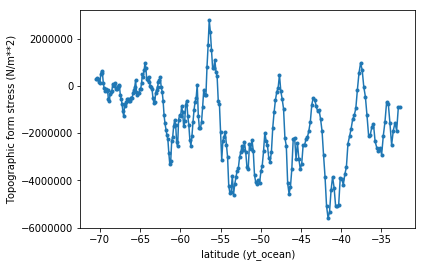

In [4]:
lat = dsx1.yt_ocean[100:360]
plt.plot(lat,np.sum(ts,axis=1),'.-')
plt.xlabel('latitude (yt_ocean)')
plt.ylabel('Topographic form stress (N/m**2)')

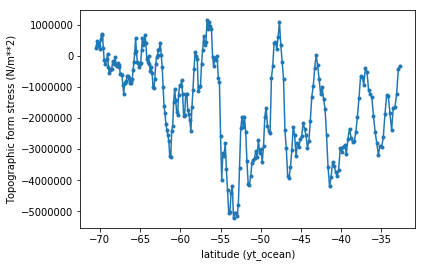

In [444]:
lat = dsx1.yt_ocean[100:360]
plt.plot(lat,np.sum(ts,axis=1),'.-')
plt.xlabel('latitude (yt_ocean)')
plt.ylabel('Topographic form stress (N/m**2)')

## sum form stress between latitude ~[30S, 70S] in unit N/m

In [ ]:
np.sum(pf[:,100:360,:])

## sum wind stress at same location in same unit

In [ ]:
dxu = dsx1.dxu.mean('time') ## dxu
taux = dxu*dsx2.tau_x.mean('time')  ## tau_x
tt =taux.sum('xu_ocean')

In [ ]:
tt[100:360].sum('yu_ocean')

## Comment No.1: Form stress/wind stress = ~85.5% +/-0.5% (depends on how the difference between dht and $\sum dz$ are distributed.)

### 

In [445]:
p_dens=np.zeros([50,1080,1440])

for yy in range(100,400):
    dx=dsx1.dxt.isel(yt_ocean=yy).max('xt_ocean').values
    zloc1,xloc1=np.where(mark[:,yy,:]==1)
    zloc2,xloc2=np.where(mark[:,yy,:]==-1)
    zloc3,xloc3=np.where(mark[:,yy,:]==2)
    unique, counts = np.unique(zloc1, return_counts=True)
    tmp=0
    x1=0
    x2=0
    for j in range(0,len(unique)):
        zloc=unique[j]
        zlen=counts[j]            
        if xloc1[tmp]-xloc2[tmp] >0:
            for k in range(0,zlen):
                x1=xloc1[tmp+k]
                x2=xloc2[tmp+k] 
                p_dens[zloc,yy,x2:x1+1]=np.sum(pf[zloc,yy,x2:x1+1])/dx/(x1+1-x2)
        elif xloc1[tmp]-xloc2[tmp] <0:
            x1=xloc1[tmp]
            x2=xloc2[tmp+zlen-1]
            p_dens[zloc,yy,0:x1+1]=(np.sum(pf[zloc,yy,0:x1+1])+np.sum(pf[zloc,yy,x2:]))/dx/(x1+1-x2+1440)           
            p_dens[zloc,yy,x2:]=(np.sum(pf[zloc,yy,0:x1+1])+np.sum(pf[zloc,yy,x2:]))/dx/(x1+1-x2+1440)                       
            for k in range(1,zlen):
                x1=xloc1[tmp+k]
                x2=xloc2[tmp+k-1]
                p_dens[zloc,yy,x2:x1+1]=np.sum(pf[zloc,yy,x2:x1+1])/dx/(x1+1-x2)
        tmp=tmp+zlen
    for n in range(0,len(zloc3)):
        p_dens[zloc3[n],yy,xloc3[n]]=pf[zloc3[n],yy,xloc3[n]]/dx
    p_dens[np.amax(zloc1)+1,yy,:]=np.sum(pf[np.amax(zloc1)+1,yy,:])/dx/1440
    

## Calculate $\int_z \Delta p*\Delta z/\Delta x$ at z axis

In [468]:
res = np.sum(p_dens[:,100:400,:],axis=0)

In [469]:
np.shape(res) # check the shape

(300, 1440)

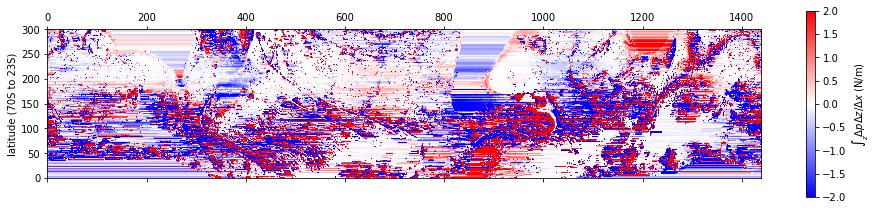

In [496]:
plt.matshow(res,cmap='bwr',origin='lower',vmin=-2,vmax=2)
plt.colorbar(label='$\int_z \Delta p\Delta z/\Delta x$ (N/m)')
plt.ylabel('latitude (70S to 23S)')

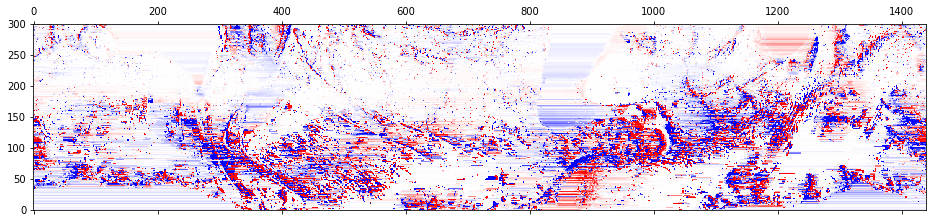

In [493]:
## change the max&min of colorbar to see the fluctuation structure
plt.matshow(res,cmap='bwr',origin='lower',vmin=-10,vmax=10)        

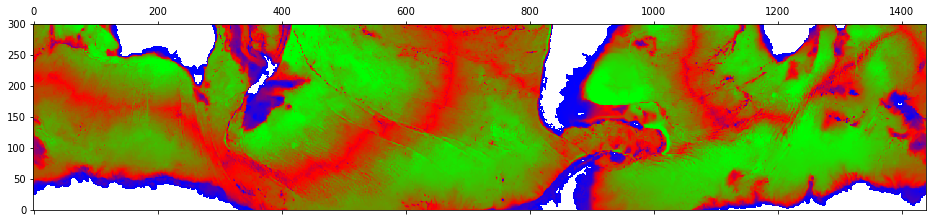

In [491]:
## Compare with the ocean depth ht structure
depth=dsx1.ht
plt.matshow(depth[100:400,:],origin='lower',cmap='brg')


## Comment No.2: 
## The fluctuations in the form stress density is caused by the ocean depth ht. Maybe that means our model fits the real case better.